In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
from scipy.io import wavfile 
import os

## Generating Signal

In [10]:
## Set parameters
filename = "test.txt"
# Frequency encodings in Hz
low_freq = 1000
high_freq = 5103 # Chose something that's coprime with low_freq

fs = 44100 # Usually 44100 or 48000 fps 
t = .01
max_amp = 32767 # Because of signed 16 bit integers


In [11]:
#Import text and store as a string
contents = "" 
with open(filename, "r") as f: 
    contents = f.read() 
    
### Convert contents to binary string bin_contents 
bin_contents = "".join(format(ord(c), '08b') for c in contents) #08b means 0 pad and 8 length

# Generate wave 
wave = [] 
for b in bin_contents:
    if b == '0':
        freq = low_freq 
    elif b == '1':
        freq = high_freq 
    else:
        print(b)    
    waveform = np.sin(2 * np.pi * freq * np.arange(t * fs) / fs) 
    waveform_ints = np.int16(max_amp * waveform)
    wave = np.append(wave, waveform_ints)
print("Wave shape: ", np.shape(wave))


### DOESNT WORK ON MACOS I THINK - CHANGE TO SD.PLAY
# write('first_gen.wav', fs, wave.astype(np.dtype('i2')))
# os.system("aplay first_gen.wav")


Wave shape:  (116424,)


## Recording

In [12]:
## Set parameters 

fs = 44100 # Usually 44100 or 48000 fps 
duration = 5  # seconds
t = 0.01 # How many seconds each frequency plays for 
filename = 'rec.wav'

freq_0 = 1000 
freq_1 = 5103 
freq_error = 50

In [13]:
# I'm using channels=1, most audio recording uses 2 channels because 
# of two headphone speakers (I think) but I think 1 channel is better 
# for plotting data

# my_recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
### JIANSHU, for testing type my_recording = sd play and rec here 


sd.wait()
sd.stop()

print("Shape of recording data: ", np.shape(my_recording))

print('Done recording')

# wavfile.write(filename, fs, my_recording)

# Make sure `python -m sounddevice` or `sd.query_devices()` says
# you're connected to both *in* and *out* channels. 

NameError: name 'my_recording' is not defined

## Post-Processing

In [14]:
# Read the file - we'll have to change this to do while recording 
# SOURCE: https://pythondsp.rob-elder.com/loading-wav-files-and-showing-frequency-response/
sample_rate, data = wavfile.read(filename) 
print("Sample rate (should be same as fs): ", sample_rate)
print("Data shape (should be 1-dimensional): ", data.shape)
samples = data.shape[0]

Sample rate (should be same as fs):  44100
Data shape (should be 1-dimensional):  (116424,)


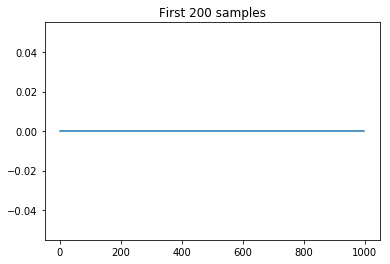

In [15]:
plt.title("First 200 samples")
plt.plot(data[:1000])
plt.show()

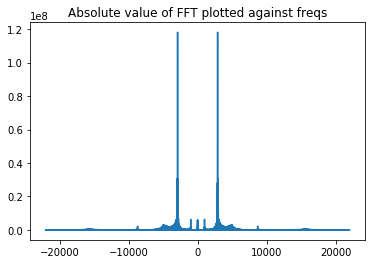

[18.93939394 19.31818182 19.6969697  20.07575758 20.45454545 20.83333333
 21.21212121 21.59090909 21.96969697 22.34848485]


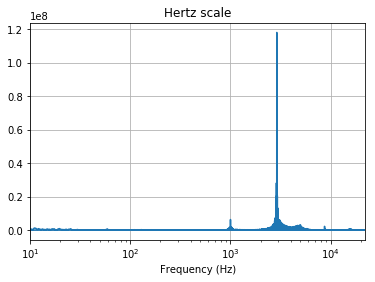

In [16]:
### This figures out frequencies for the *WHOLE* recording. 
data_fft = np.fft.fft(data)
fft_abs = abs(data_fft)
freqs = np.fft.fftfreq(samples, 1/sample_rate)
plt.title("Absolute value of FFT plotted against freqs")
plt.plot(freqs, fft_abs)
plt.show()

print(freqs[50:60])

# Let's use a better scale: the log scale which shows freqs in Hertz 
plt.xlim([10, sample_rate/2]) 
plt.xscale('log')
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.title('Hertz scale')
# The original example used freqs[:int(freqs.size/2)] but I don't 
# think it matters
plt.plot(freqs, fft_abs)
plt.show()

In [17]:
print('Mode: ', freqs[np.argmax(fft_abs)])
print('Index of mode: ', np.argmax(fft_abs))

# We have to multiply by 5 to get correct index - I'm not sure why but below you can see that the mode index 
# is 5 times the mode 
print('Mass of 0 signal: ', max(fft_abs[(5 * freq_0 - freq_error):(5 * freq_0 + freq_error)]))
print('Mass of 1 signal: ', max(fft_abs[(5 * freq_1 - freq_error):(5*freq_1 + freq_error)]))

Mode:  2900.0
Index of mode:  7656
Mass of 0 signal:  332796.2329106426
Mass of 1 signal:  34247.93550885196


Chunk length:  441
0
Number of chunks (should be duration / t):  500
0
False
1
False
2
False
3
False
4
False
5
False
6
False
7
False
8
False
9
False
10
False
11
False
12
False
13
False
14
False
15
False
16
False
17
False
18
False
19
False
20
False
21
False
22
False
23
False
24
False
25
False
26
False
27
False
28
False
29
False
30
False
31
False
32
False
33
False
34
False
35
False
36
False
37
False
38
False
39
False
40
False
41
False
42
False
43
False
44
False
45
False
46
False
47
False
48
False
49
False
50
False
51
False
52
False
53
False
54
False
55
False
56
False
57
False
58
False
59
False
60
False
61
False
62
False
63
False
64
False
65
False
66
False
67
False
68
False
69
False
70
False
71
True
72
True
73
True
74
False
75
False
76
True
77
False
78
False
79
True
80
True
81
False
82
True
83
True
84
True
85
False
86
False
87
True
88
True
89
False
90
True
91
False
92
True
93
False
94
False
95
True
96
True
97
False
98
False
99
True
100
True
101
False
102
False
103
True
104
True
105
False


ValueError: Dimension n should be a positive integer not larger than the shape of the array along the chosen axis

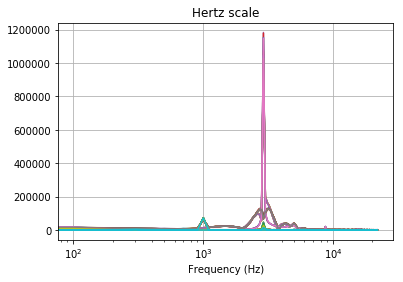

In [22]:
### This figures out frequencies for every interval of t seconds. 
### This is what we use to decode but it has to be perfectly 
### aligned with when the first signal starts. 

data += []

samp_p_chunk = int(t * fs)
start = int(0 * fs) # Index of frame when signal starts
end = int(duration * fs) # Index of frame when signal stops
chunks = [data[i:i + samp_p_chunk] 
          for i in range(start, end, samp_p_chunk)]
print('Chunk length: ', samp_p_chunk)
print('Number of chunks (should be duration / t): ', len(chunks)) 

result_bit_string = ""
i = 0
for chunk in chunks: 
    print(i)
    i += 1
    c_fft = np.fft.fft(chunk)
    c_fft_abs = abs(c_fft)
    
    c_samples = chunk.shape[0]
    c_freqs = np.fft.fftfreq(c_samples, 1/sample_rate)
        
    # Get maximum frequency from fft graph 
    
    ### Here's a potential problem: the c_freqs array here has each entry differ by 100
    # c_freqs[50:60] is [5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900] but 
    # in the whole sample (ie the freqs array 2 cells above) it differs by .2 
    mass_0 = max(c_fft_abs[9:12])
#     mass_1 = max(c_fft_abs[12:15]) 
    mass_1 = max(c_fft_abs[50:53])
    print(mass_0 > mass_1)
    if mass_0 > mass_1: 
        result_bit_string += '0'
    else: 
        result_bit_string += '1'
    
#     print(len(c_fft_abs))
#     print(len(c_freqs))
#     print(5 * freq_0 - freq_error)
#     print(5 * freq_0 + freq_error)
#     mass_0 = max(c_fft_abs[(5 * freq_0 - freq_error):(5 * freq_0 + freq_error)])
#     mass_1 = max(c_fft_abs[(5 * freq_1 - freq_error):(5 * freq_1 + freq_error)]) 
    
    # FFT for first chunk
    if chunk.all() == chunks[0].all():
        # plt.xlim([10, sample_rate/2]) 
        plt.xscale('log')
        plt.grid(True)
        plt.xlabel('Frequency (Hz)')
        plt.title('Hertz scale')
        plt.plot(c_freqs, c_fft_abs)

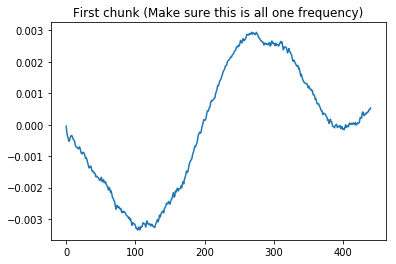

In [36]:
# Sanity check: plots first chunk so we know it captures a whole signal
plt.title("First chunk (Make sure this is all one frequency)")
plt.plot(chunks[0])
plt.show()

In [ ]:
plt.plot